LET's refer to this notebook later! There is a small `pandas` df thing that is handled here.

In [43]:
import graph_create, voronoi_local, jaccard_similarity, figure_plot, figure_save

import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import matplotlib as mpl

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [44]:
sample = 'C2-1'
C2_dot_folder = 'environmental/dot_images/control_dots'
C2_vein_folder = 'environmental/vein_graphs/control_txt'

G = graph_create.graph_creation(sample, dot_folder= C2_dot_folder, vein_folder= C2_vein_folder)

# sample = 'H4-1'
# H4_dot_folder = 'environmental/dot_images/heat_dots'
# H4_vein_folder = 'environmental/vein_graphs/heat_txt'

# G = graph_create.graph_creation(sample, dot_folder= H4_dot_folder, vein_folder= H4_vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



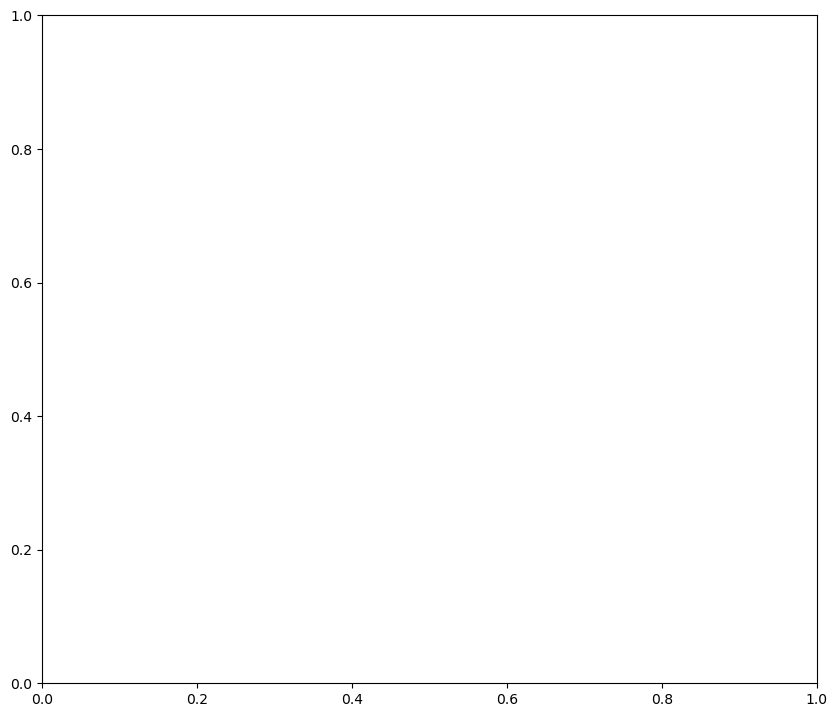

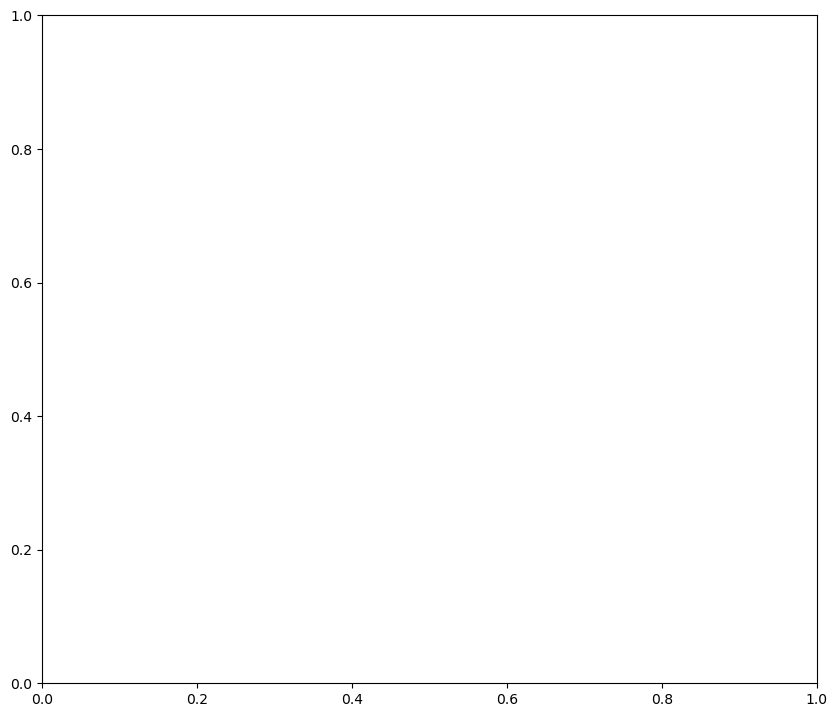

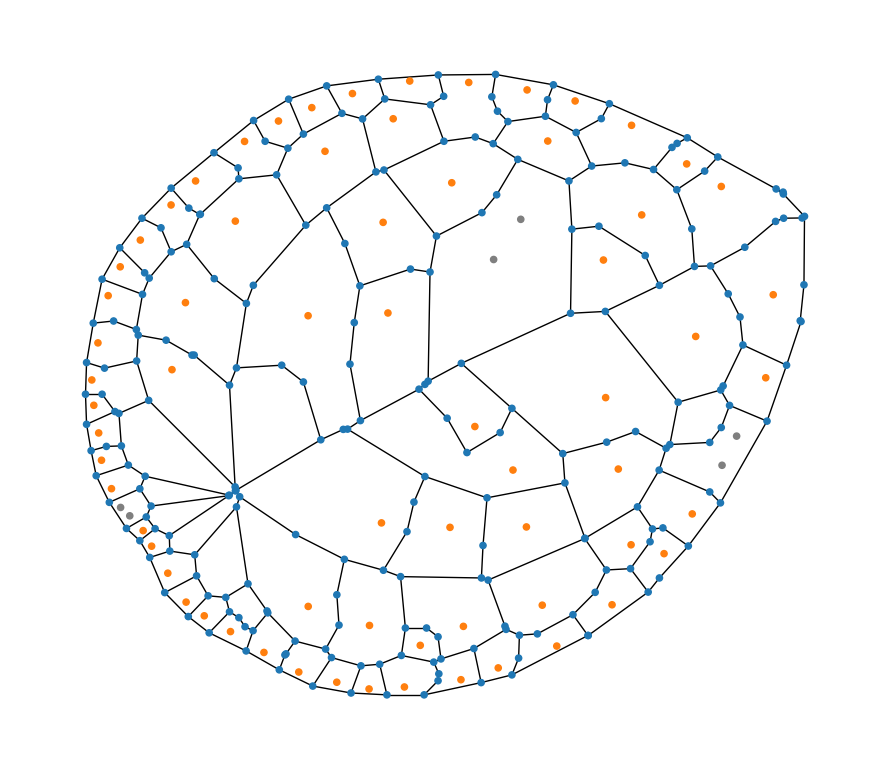

In [45]:
# figure_plot.quick_plot(G)
figure_plot.quick_plot(G)

-----

## Perform local tests

For the "one face - one dot" dots, we locally test the voronoi properties between it and other eligible dots in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same.

In [46]:
# local tests:
adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
rst[2]

,mean angle error,std angle error,mean distance error,std distance error
0,10.629277,8.846086,0.270683,0.204618


We use the centroid dots and random dots in the face as baselines for the local test.

In [47]:
# baseline local tests:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)

In [48]:
centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

-----

## Visualize local test

we color the dual edges (by connecting dots) to represent test performance.

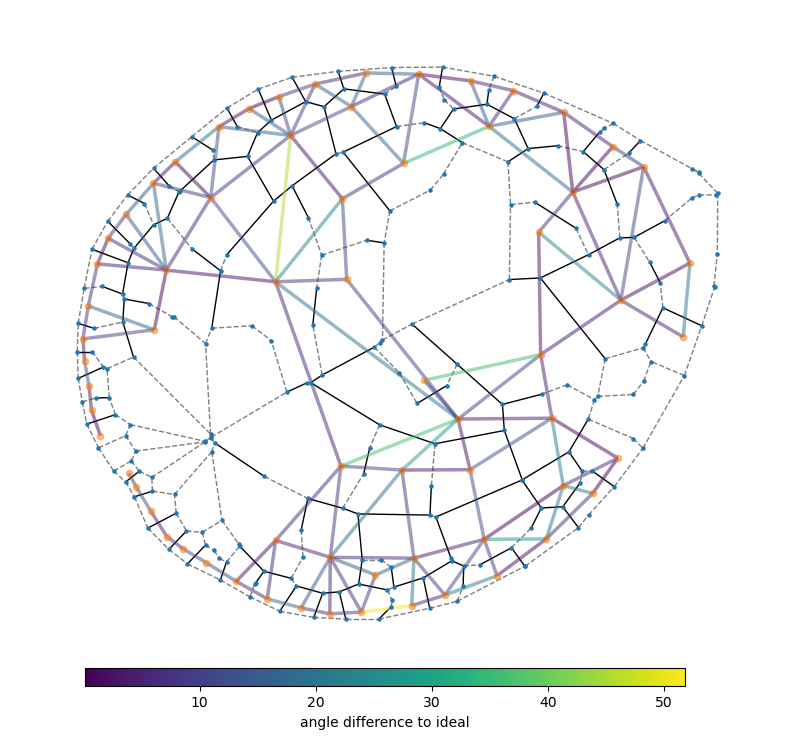

In [49]:
G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
figure_plot.plot_dual(G, G_dual, attr = "angle")

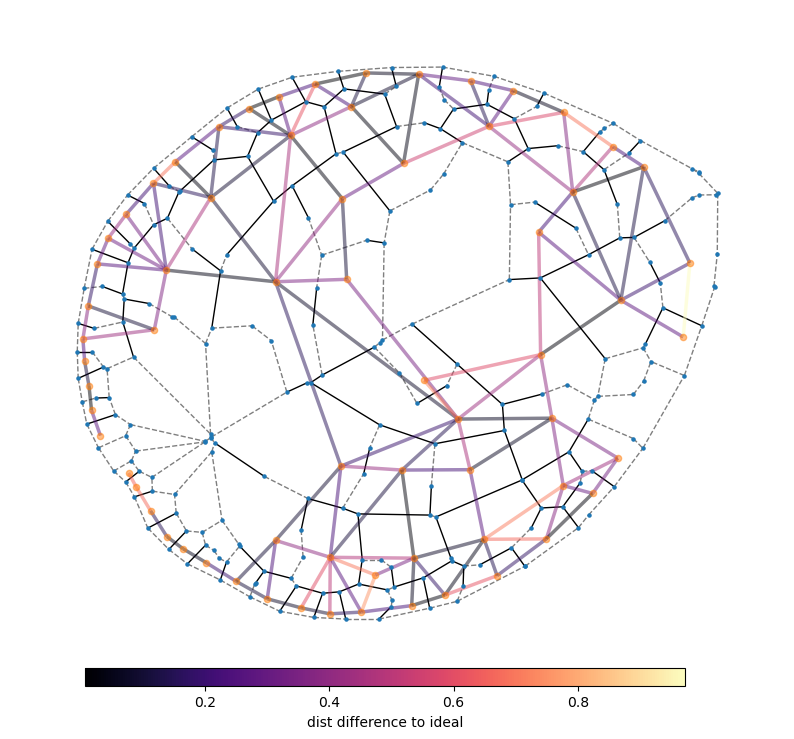

In [50]:
figure_plot.plot_dual(G, G_dual, attr = "dist")

-------
## Visualize baseline

We plot location of the baseline nodes (centroids in purple, random in red) in comparsion to that of the dots.

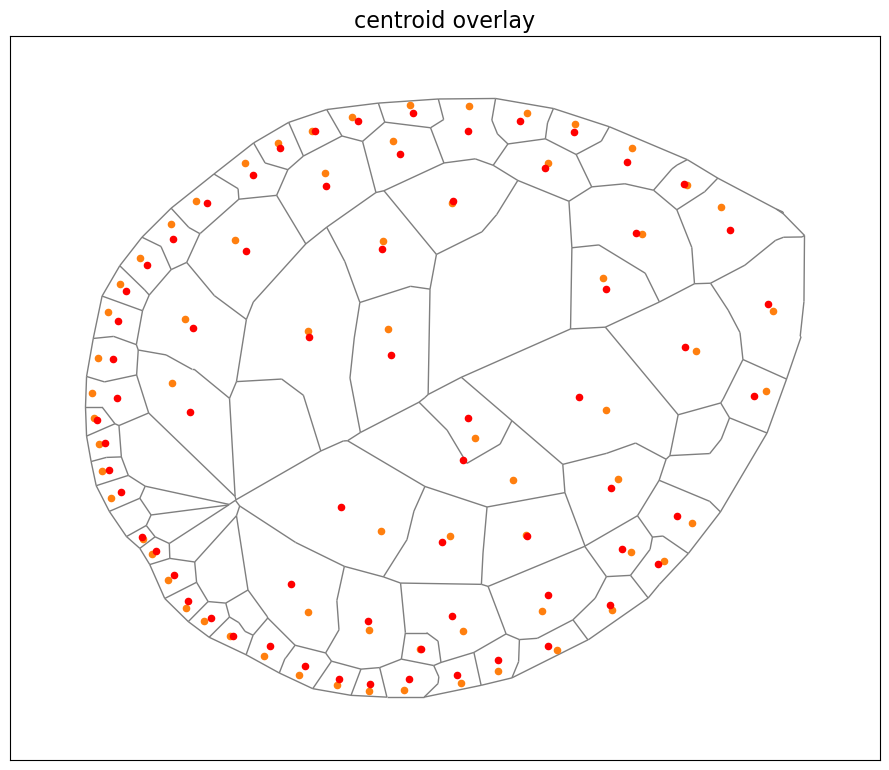

In [51]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'centroid')

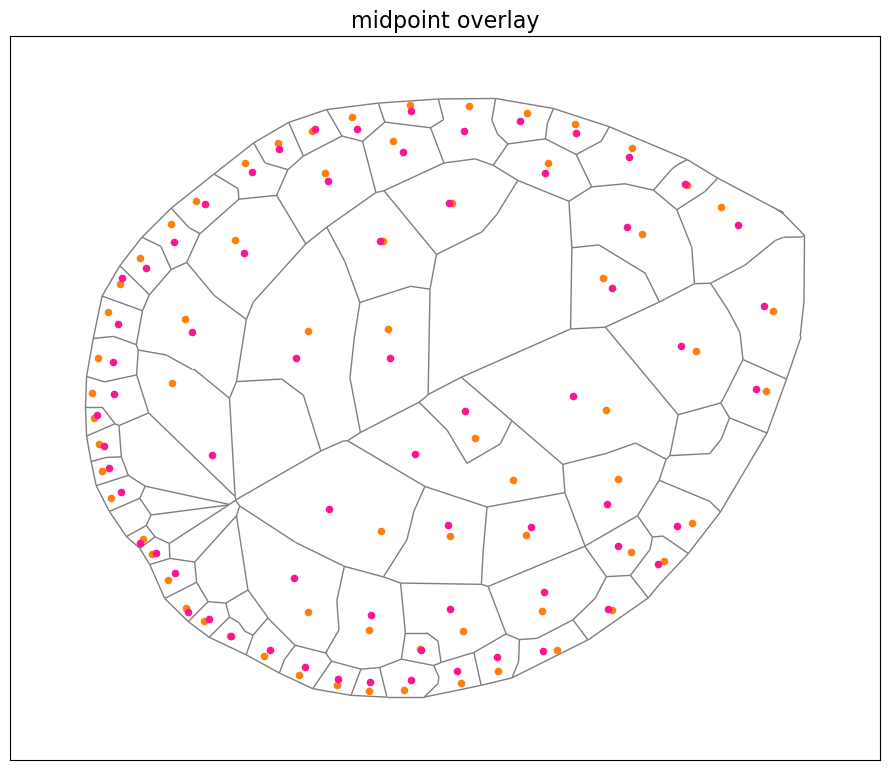

In [52]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'midpoint')

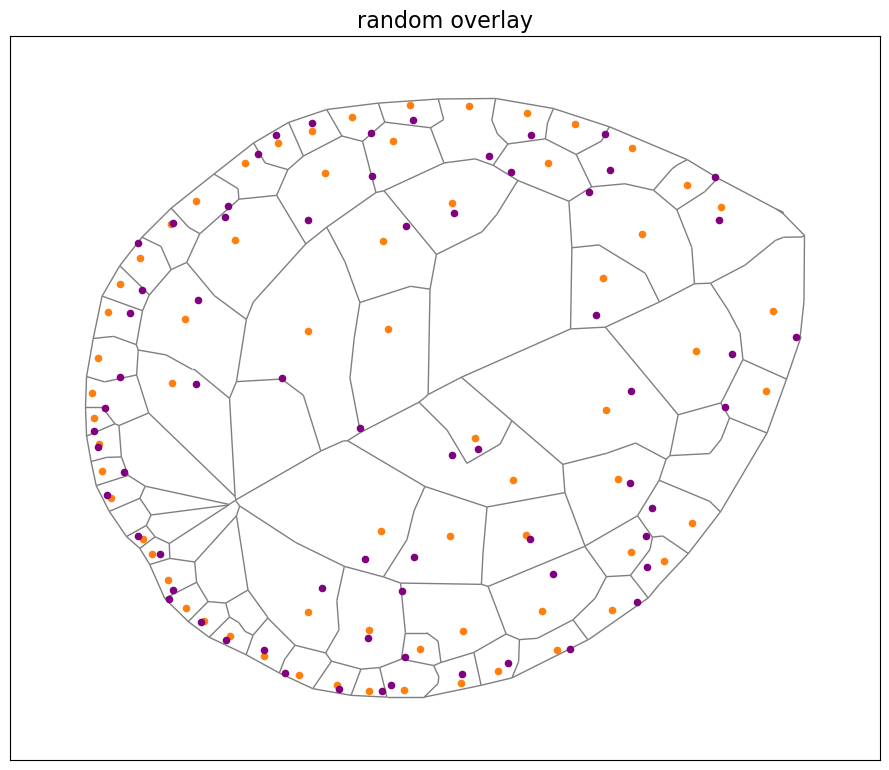

In [53]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'random')

-------
## Statistically compare dot-pair performance in all passed faces

In [54]:
# combine local test results:
rst_df = rst[1]
rst_df['type'] = 'dot'
cent_df = centroid_rst[1]
cent_df['type'] = 'centroid'
mid_df = midpoint_rst[1]
mid_df['type'] = 'midpoint'
rand_df = random_rst[1]
rand_df['type'] = 'random'

df = pd.concat([rst_df, cent_df, mid_df, rand_df])

In [55]:
rst_df.describe()

,angle_diff,dist_diff
count,127.000000,127.000000
mean,10.629277,0.270683
std,8.846086,0.204618
min,0.113264,0.007084
25%,4.700675,0.103340
50%,8.881540,0.226721
75%,14.132943,0.395534
max,51.823934,0.972352


In [56]:
df

,angle_diff,dist_diff,type
0,4.505487,0.252994,dot
1,14.422156,0.110910,dot
2,8.067925,0.380895,dot
3,9.564220,0.430291,dot
4,3.805214,0.007084,dot
...,...,...,...
122,9.587307,1.400643,random
123,30.881099,0.676877,random
124,28.239088,1.312216,random
125,3.615516,0.502753,random


In [57]:
_, p_angle = mannwhitneyu(random_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(random_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)


Mann Whitney U test result for angle error (random v.s. dot): 4.9722653228538244e-08
Mann Whitney U test result for percent distance error: 2.483754349633827e-20


In [58]:
_, p_angle = mannwhitneyu(midpoint_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(midpoint_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)

Mann Whitney U test result for angle error (random v.s. dot): 0.006643746881846615
Mann Whitney U test result for percent distance error: 3.0054093467329695e-08


In [59]:
_, p_angle = mannwhitneyu(centroid_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(centroid_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)

Mann Whitney U test result for angle error (random v.s. dot): 0.23248908732015205
Mann Whitney U test result for percent distance error: 1.4117521747370577e-05


In [60]:
# plot shaded polygons:

node_position_G = {}
    
node_position_dual = {}


for node in G.nodes:
    node_position_G[node] = node

edge_style = ['solid' if G.edges[e]['shared'] =='tested_shared' else 'dashed' for e in G.edges]
edge_col = ['black' if G.edges[e]['shared'] =='tested_shared' else 'C7' for e in G.edges]

for node in G_dual.nodes:
    node_position_dual[node] = node

fig, ax = plt.subplots(figsize=(10,10/G.graph['ratio']))

for i in range(len(G.graph['faces_passed'])):
    p = mpl.patches.Polygon(G.graph['faces_passed'][i], facecolor = 'C7', alpha = .1)
    ax.add_patch(p)

nx.draw_networkx_edges(G, pos=node_position_G, edge_color = edge_col, style = edge_style, ax = ax) 

nx.draw(G_dual, pos=node_position_dual, node_size= 20,  node_color= 'seagreen', 
        edge_color ='seagreen',  width = 1, ax = ax)


  
plt.show()   



NameError: name 'nx' is not defined

------
## Plot distributions of errors

We plot the local test result distributions.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [61]:
# this is important! Because after we concatenate, we duplicate index as well which penguin will throw an error when plotting.

df.reset_index(level=0, inplace=True)

In [62]:
df

,index,angle_diff,dist_diff,type
0,0,4.505487,0.252994,dot
1,1,14.422156,0.110910,dot
2,2,8.067925,0.380895,dot
3,3,9.564220,0.430291,dot
4,4,3.805214,0.007084,dot
...,...,...,...,...
503,122,9.587307,1.400643,random
504,123,30.881099,0.676877,random
505,124,28.239088,1.312216,random
506,125,3.615516,0.502753,random


In [63]:
sns.histplot(df, x = 'angle_diff', hue = 'type')
plt.show()

NameError: name 'sns' is not defined

In [64]:
sns.histplot(df, x = 'dist_diff', hue = 'type')
plt.show()

NameError: name 'sns' is not defined

In [65]:
def plot_dist(df, test = 'angle'):

    fig, ax = plt.subplots(nrows =2, figsize = (8, 12))
    
    sns.histplot(df, x = f'{test}_diff', hue = 'type', kde = True, ax = ax[0])

    ax[1] = sns.violinplot(x = f'{test}_diff', y = 'type' , 
                            data = df, inner = 'quartile')
    for l in ax[1].lines:
        l.set_linestyle('--')
        l.set_linewidth(1)
        l.set_color('brown')
        l.set_alpha(0.8)
    for l in ax[1].lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.2)
        l.set_color('black')
        l.set_alpha(0.8)
    
    fig.suptitle(f'{test} difference distribution', fontsize = 16)

    #fig.tight_layout() # no they overlaps

    plt.show()
    return

In [66]:
plot_dist(df, test = 'dist')

NameError: name 'sns' is not defined

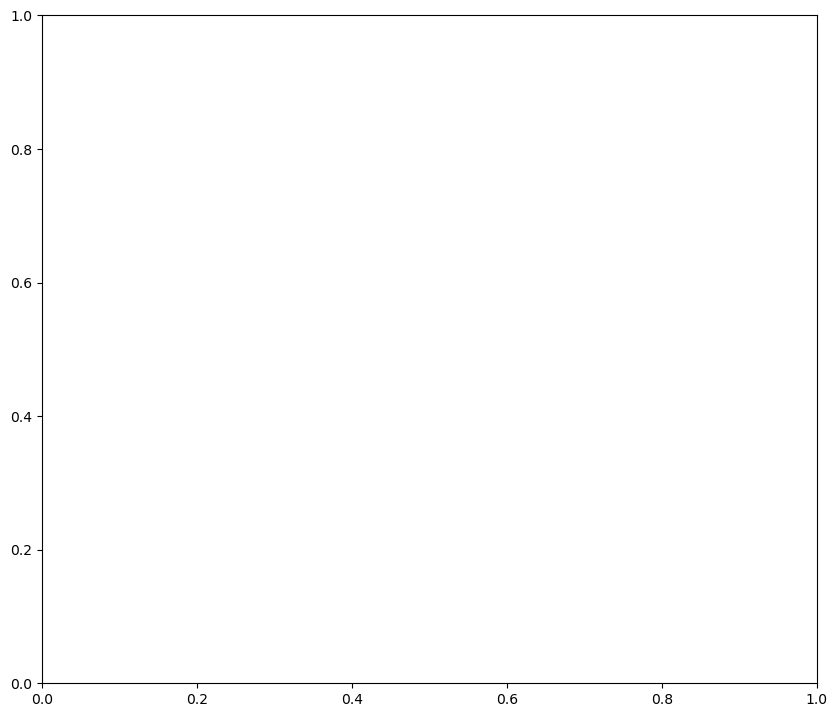

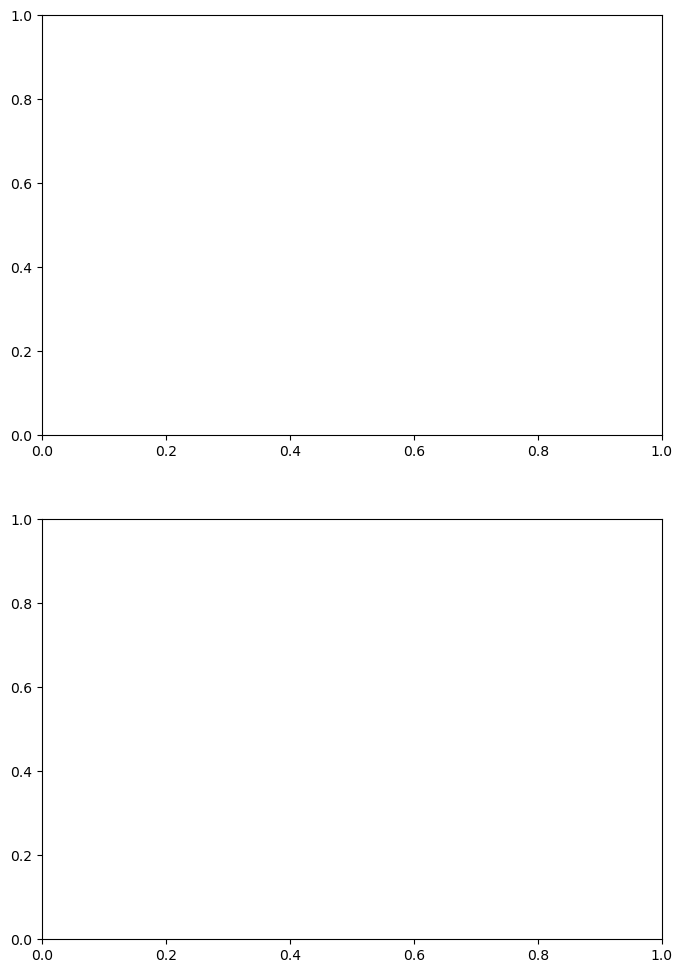

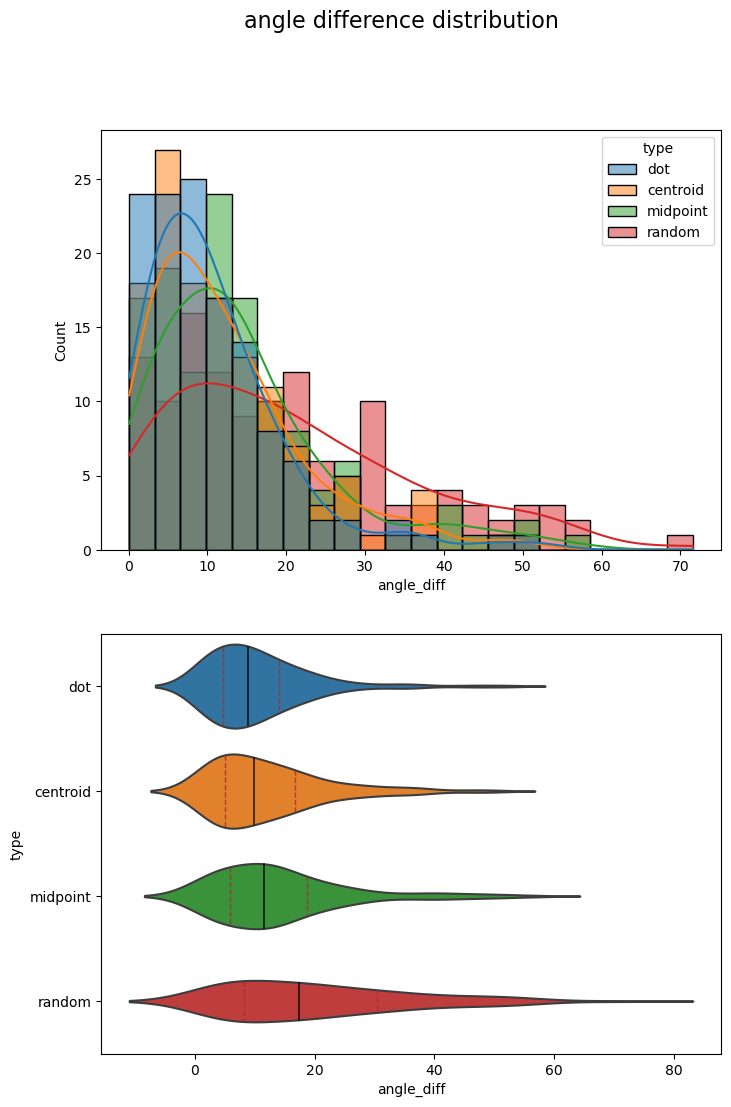

In [67]:
figure_plot.plot_dist(df, test = 'angle')

-------
## Visualize Voronoi Overlay

Plot voronoi diagram generated by the dots as seeds. Later we'll perform area overlap test for faces.

In [68]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)

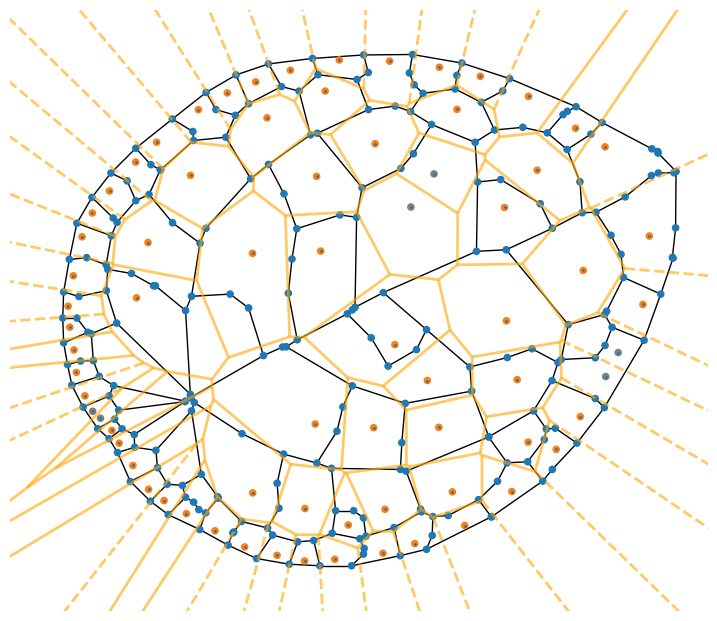

In [69]:
figure_plot.plot_voronoi(G, vor)

In [70]:
baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

In [71]:
baseline_summary

,angle_mean,angle_std,dist_mean,dist_std
dot,10.629277,8.846086,0.270683,0.204618
centroid,12.198404,9.806516,0.440061,0.314830
midpoint,14.100681,11.225799,0.505385,0.341520
random,20.402127,15.353836,0.821297,0.517472


-------
### Visualize where dots perform less well compared to centroid:

In [72]:
dual_edge_list = []
M = len(shared_edges_mat)
for i in range(M):
    node1 = G.graph['dots_passed'][i]
    for j in range(i+1, M):
        # if they are adjacent:
        if adj_faces_mat[i][j]:
            node2 = G.graph['dots_passed'][j]
            dual_edge_list.append((node1, node2))

G_dual_bad_angles = graph_create.create_dual_subgraph(G_dual, rst_df, cent_df, dual_edge_list,  attr = 'angle')
G_dual_bad_dists = graph_create.create_dual_subgraph(G_dual, rst_df, cent_df, dual_edge_list, attr = 'dist')


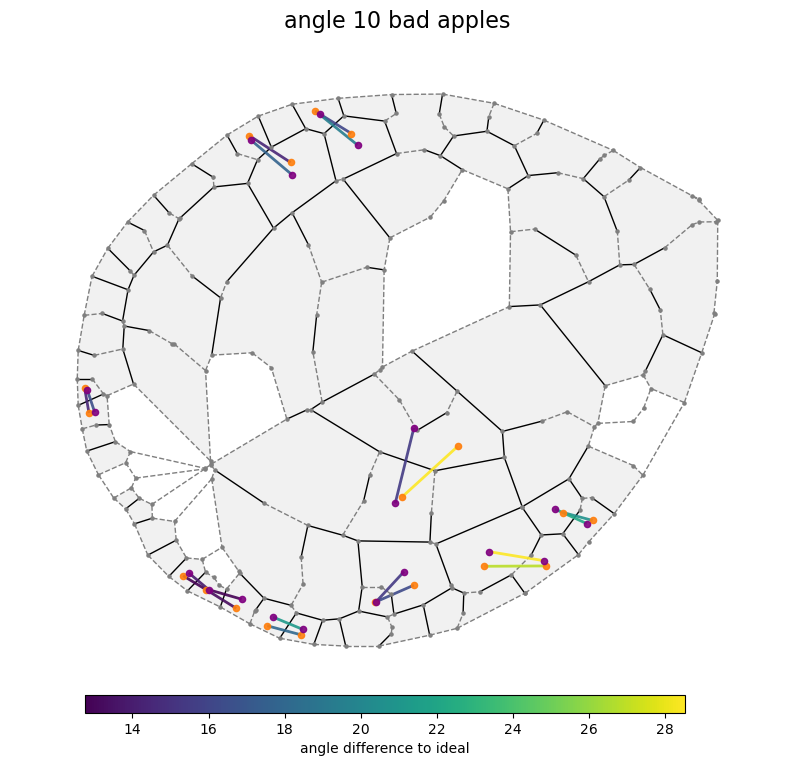

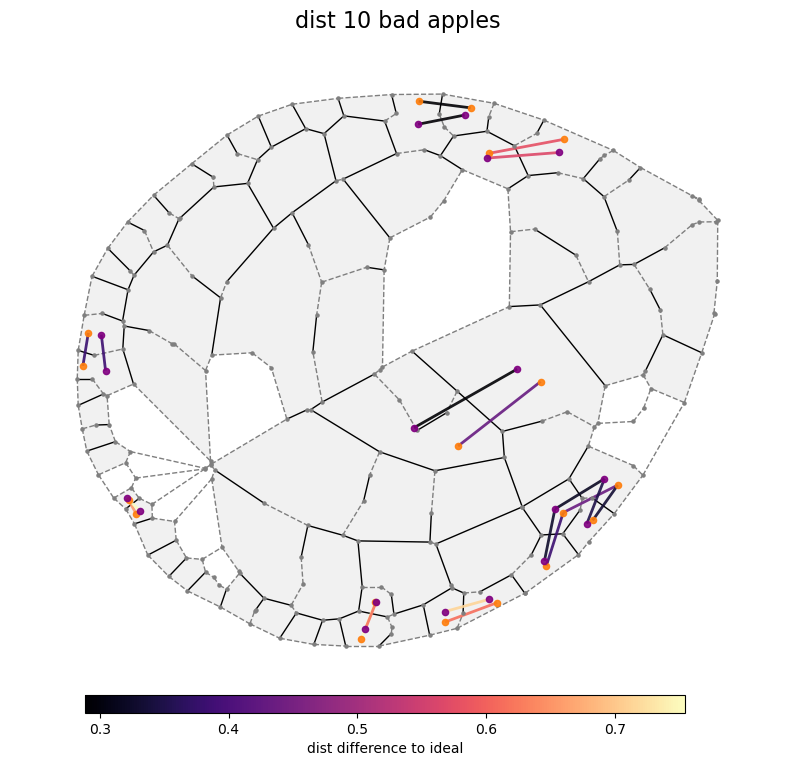

In [73]:
figure_plot.plot_subdual(G, G_dual_bad_angles, attr = "angle")
figure_plot.plot_subdual(G, G_dual_bad_dists, attr = "dist")

-------------

### Perform area test

In [74]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)
bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions, type = 'dot')

In [75]:
centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

centroid_vor = Voronoi(centroid_seeds)
midpoint_vor =  Voronoi(midpoint_seeds)
random_vor = Voronoi(random_seeds)

centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions, type= 'centroid')
midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions, type= 'midpoint')
random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions, type = 'random')

J_df = pd.DataFrame(np.array([J_list, centroid_J_list, midpoint_J_list, random_J_list ]).T, columns = ['dots', 'centroid', 'midpoint', 'random'])

J_df.head()


,dots,centroid,midpoint,random
0,0.409525,0.632890,0.538951,0.563734
1,0.507099,0.629790,0.458067,0.463591
2,0.420202,0.469018,0.451871,0.182377
3,0.846426,0.692919,0.652645,0.425146
4,0.432404,0.535254,0.520317,0.488801


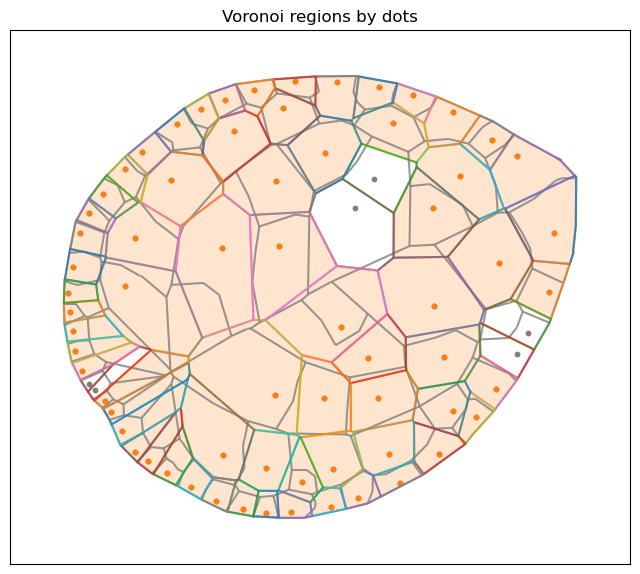

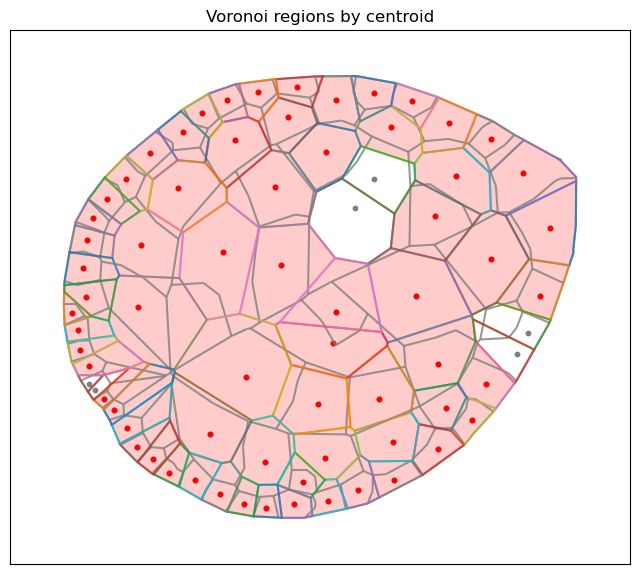

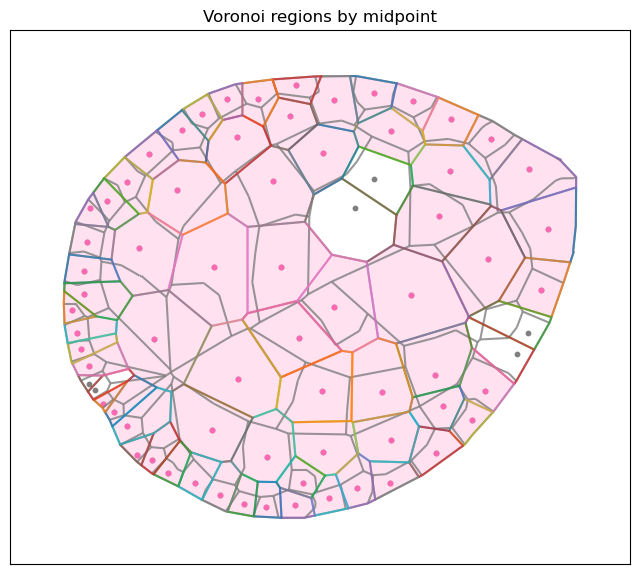

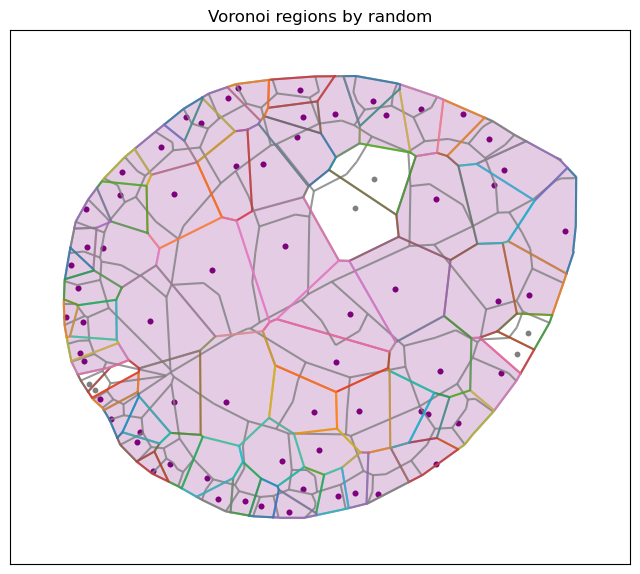

In [76]:
single_dot = [G.nodes[seed]['type'] == 'single_dot' for seed in seeds]

figure_plot.plot_vor_regions(G, seeds, single_dot, bounded_regions, dot_type = 'dots')
figure_plot.plot_vor_regions(G, centroid_seeds, single_dot, centroid_bounded_regions, dot_type = 'centroid')
figure_plot.plot_vor_regions(G, midpoint_seeds, single_dot, midpoint_bounded_regions, dot_type = 'midpoint')
figure_plot.plot_vor_regions(G, random_seeds, single_dot, random_bounded_regions, dot_type = 'random')

### 05/09/22: 
- __two functions__: 
    - how many hydathodes
    - testable areas (must have written already but get that out!)

In [77]:
def hydathode_num(G):
    hydatode_count = 0
    single_count = 0
    for n in G:  
        if G.nodes[n]['type'] != 'vein':
            hydatode_count += 1
            if G.nodes[n]['type'] == 'single_dot':
                single_count += 1
    return hydatode_count, single_count

from shapely.geometry import Polygon 

def area_sum(G):
    faces = G.graph['faces_passed']
    area_sum = 0
    for face in faces:
        face_poly = Polygon(face)
        area_sum += face_poly.area
        blade_area = Polygon(G.graph['boundary']).area

    return blade_area, area_sum

In [78]:
hydathode_num(G)

(73, 67)

In [79]:
area_sum(G)

(4795479.5, 4079795.5)

### 05/13/22:

- test if we can easily plot J_similarity errors

In [80]:
import shapely
import networkx as nx
import matplotlib as mpl

We can inclulde this afater we talk about the develop. constraints:

We added a difference_calculation feature to our similarity test function.

In [81]:
def plot_overlap_diff(type = 'dot', bounded_regions = bounded_regions):
    fig, ax = plt.subplots(figsize = (8, 8/G.graph['ratio']))

    node_positions = {}

    for node in G.nodes:
        node_positions[node] = node

    dot_color = {'dot':'C1', 'centroid':'red','midpoint': 'hotpink', 'random':'purple'}
    color = dot_color[type]

    # plot veins:     
    nx.draw_networkx_edges(G, pos=node_positions, edge_color = 'C7', ax = ax, width = 1.5, alpha = .8) 

    # plot voronoi polygons:
   
    for i in range(len(bounded_regions)):
        ax.plot(np.array(bounded_regions[i])[:,0], np.array(bounded_regions[i])[:,1], alpha = .7)

    # plot diff patches:
    for geom in G.graph[f'diff_geom_{type}']:  

        if isinstance(geom, shapely.geometry.polygon.Polygon):
            contour = list(geom.exterior.coords)
           
            if len(contour):
                p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                ax.add_patch(p)
                
            if len(list(geom.interiors)):
                interior = list(geom.interiors[0].coords)
                p_in = mpl.patches.Polygon(contour, facecolor = 'white', alpha = 1)
                ax.add_patch(p_in)
                
        else: # multipolygon.MultiPolygon
            for ploy in geom:
                contour = list(ploy.exterior.coords)
                if len(contour):
                    p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                    ax.add_patch(p)
                    
                if len(list(ploy.interiors)):
                    interior = list(ploy.interiors[0].coords)
                    p_in = mpl.patches.Polygon(interior, facecolor = 'white', alpha = 1)
                    ax.add_patch(p_in)

    plt.show()


        

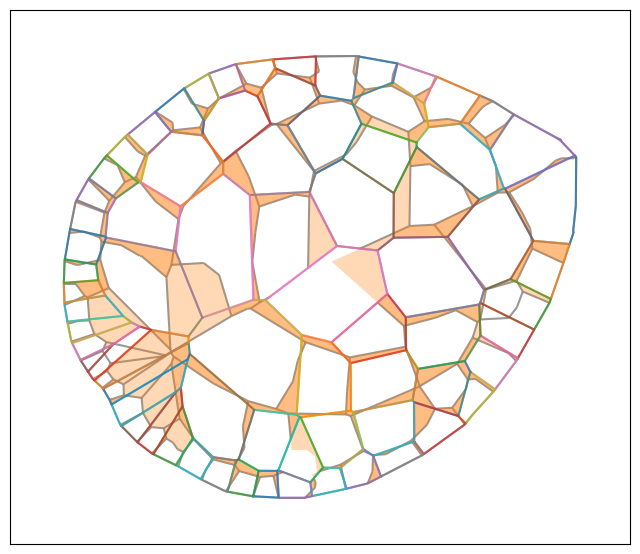

In [82]:
plot_overlap_diff()

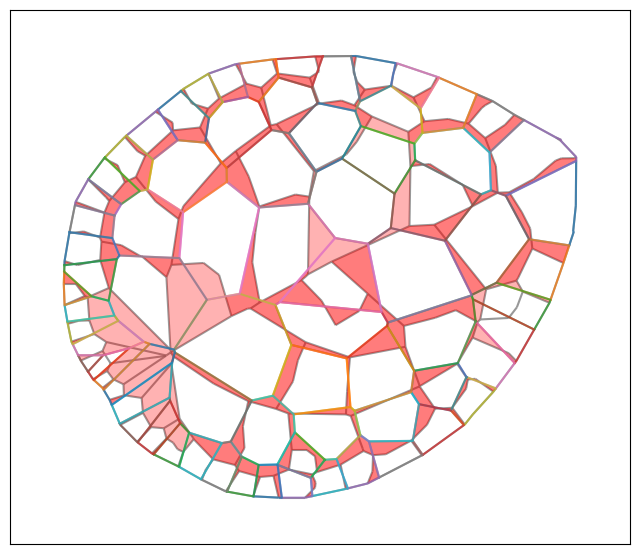

In [83]:
plot_overlap_diff('centroid', centroid_bounded_regions)

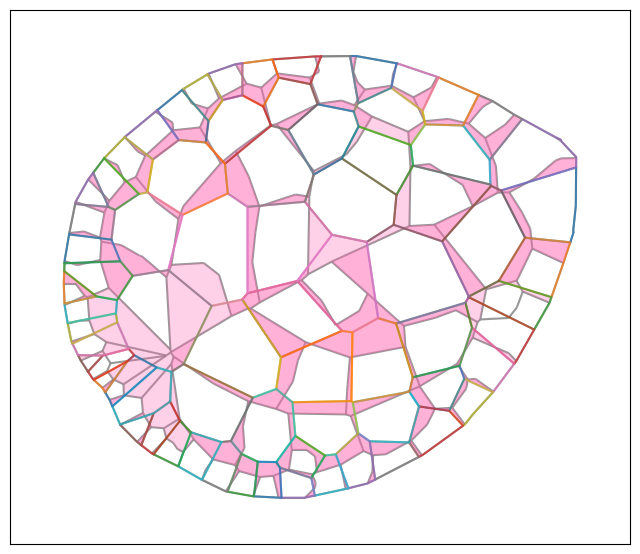

In [84]:
plot_overlap_diff('midpoint', midpoint_bounded_regions)

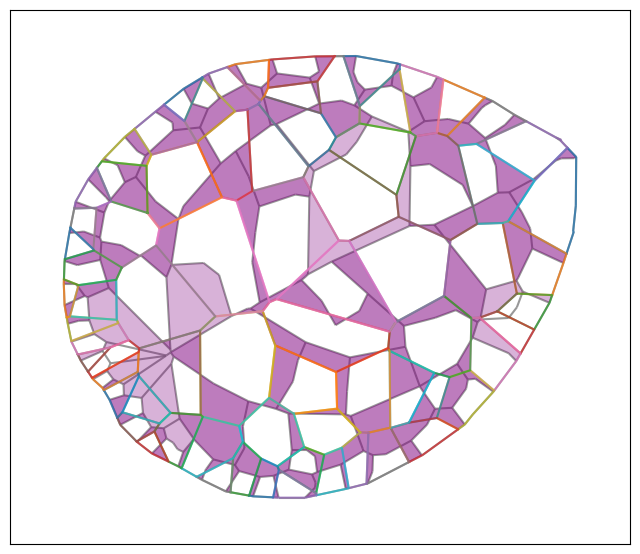

In [85]:
plot_overlap_diff('random', random_bounded_regions)